In [107]:
#Hybrid 6
#import all the files and modules required
# from google.colab import files
import pandas
import numpy as np
import matplotlib.pyplot as plt
import io
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import *
from sklearn.model_selection import KFold
from mpl_toolkits import mplot3d
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import time

In [108]:
#define all the functions that would be used later on
class Stress:
  #filter data to reduce data points to values on the top or bottom surface of the beams
  # where bending is maximum/minimum, i.e y is maximum/minimum
  @staticmethod
  def func(e, y):
    mina = min(y)
    maxa = max(y)
    e_new = []
    for i in range(len(y)):
      if y[i] == mina or y[i] == maxa:
        a = e[i]
        e_new.append(a)
    return e_new

  #Non - dimensionalise the beam geometry by using ratios   
  @staticmethod
  def parametrise(z, b, d, L):
    z = np.array(z)
    b = np.array(b)
    d = np.array(d)
    L = np.array(L)
    bd = b/d
    zL = z/L
    bL = b/L
    return bd, zL, bL

  #Due to the fine meshing of the beam, each element has multiple data points
  # To reduce the data, the average of all the data points is used instead for each element
  @staticmethod
  def hashsort(e, y, z, S33, b, d, L, I, W, M, sig, Diff):
  #A dictionary h is created. Each key will represent a unique value from the "e" parameter and
  #each value will be a list of tuples, where each tuple contains a single value from each of 
  #the other parameters (y, z, S33, b, d, L).
    h = {}
    for val1, val2, val3, val4, val5, val6, val7, val8, val9, val10, val11, val12 in zip(e, y, z, S33, b, d, L, I, W, M, sig, Diff):
      # For each unique value from "e", it checks if that value already exists in the dictionary h. 
      #If it does, it appends the tuple of corresponding values from the other parameters to the list
      #associated with that key. If it does not exist, it creates a new key with that "e" value and 
      #assigns the tuple of corresponding values from the other parameters as a new list
      if val1 in h:
        h[val1].append((val2, val3, val4, val5, val6, val7, val8, val9, val10, val11, val12))
      else:
        h[val1] = [(val2, val3, val4, val5, val6, val7, val8, val9, val10, val11, val12)]

    #create empty lists to store the new values
    y_new = []
    z_new = []
    S33_new = []
    b_new = []
    d_new = []
    L_new = []
    I_new = []
    W_new = []
    M_new = []
    sig_new = []
    Diff_new = []
  
    #for each key (parameter e), take the average of each different parameter
    # from all the tuples assigned to that specific key
    for key in h:
      values = h[key]
      avgy = sum(v[0] for v in values)/len(values)
      y_new.append(avgy)

      avgz = sum(v[1] for v in values)/len(values)
      z_new.append(avgz)

      avgS33 = sum(v[2] for v in values)/len(values)
      S33_new.append(avgS33)

      avgb = sum(v[3] for v in values)/len(values)
      b_new.append(avgb)

      avgd = sum(v[4] for v in values)/len(values)
      d_new.append(avgd)

      avgL = sum(v[5] for v in values)/len(values)
      L_new.append(avgL)

      avgI = sum(v[6] for v in values)/len(values)
      I_new.append(avgI)
      
      avgW = sum(v[7] for v in values)/len(values)
      W_new.append(avgW)

      avgM = sum(v[8] for v in values)/len(values)
      M_new.append(avgM)

      avgsig = sum(v[9] for v in values)/len(values)
      sig_new.append(avgsig)

      avgDiff = sum(v[10] for v in values)/len(values)
      Diff_new.append(avgDiff)


    return y_new, z_new, S33_new, b_new, d_new, L_new, I_new, W_new, M_new, sig_new, Diff_new

  #when importing the data, define the variables
  def assign_var(df0):
    e0 = np.array(df0['Element Label'])
    y0 = np.array(df0['Y'][:])
    z0 = np.array(df0['Z'][:])
    S330 = np.array(df0['S-S33'][:])
    b0 = np.array(df0['b'][:])
    d0 = np.array(df0['d'][:])
    L0 = np.array(df0['L'][:])
    I0 = np.array(df0['I'][:])
    W0 = np.array(df0['W'][:])
    M0 = np.array(df0['M'][:])
    sig0 = np.array(df0['sig'][:])
    Diff0 = np.array(df0['Diff'][:])
    

    e0 = Stress.func(e0, y0)
    b0 = Stress.func(b0, y0)
    d0 = Stress.func(d0, y0)
    z0 = Stress.func(z0, y0)
    S330 = Stress.func(S330, y0)
    L0 = Stress.func(L0, y0)
    y0 = Stress.func(y0, y0)
    I0 = Stress.func(I0, y0)
    W0 = Stress.func(W0, y0)
    M0 = Stress.func(M0, y0)
    sig0 = Stress.func(sig0, y0)
    Diff0 = Stress.func(Diff0, y0)

    y0, z0, S330, b0, d0, L0, I0, W0, M0, sig0, Diff0 = Stress.hashsort(e0, y0, z0, S330, b0, d0, L0, I0, W0, M0, sig0, Diff0)

    return y0, z0, S330, b0, d0, L0, I0, W0, M0, sig0, Diff0

In [109]:
#load in the data
df0 = pandas.read_csv('Report0.csv')
df1 = pandas.read_csv('Report1.csv')
df2 = pandas.read_csv('Report2.csv')
df3 = pandas.read_csv('Report3.csv')
df4 = pandas.read_csv('Report4.csv')
df5 = pandas.read_csv('Report5.csv') 
df6 = pandas.read_csv('Report6.csv') 
print(df5.columns.tolist())


['Element Label', '         IntPt', 'X', 'Y', 'Z', 'S-S33', 'b', 'd', 'L', 'I', 'W', 'M', 'sig', 'Diff']


In [110]:
#assign the variables to the data
y0, z0, S330, b0, d0, L0, I0, W0, M0, sig0, Diff0 = Stress.assign_var(df0)
y1, z1, S331, b1, d1, L1, I1, W1, M1, sig1, Diff1= Stress.assign_var(df1)
y2, z2, S332, b2, d2, L2, I2, W2, M2, sig2, Diff2 = Stress.assign_var(df2)
y3, z3, S333, b3, d3, L3, I3, W3, M3, sig3, Diff3 = Stress.assign_var(df3)
y4, z4, S334, b4, d4, L4, I4, W4, M4, sig4, Diff4 = Stress.assign_var(df4)
y5, z5, S335, b5, d5, L5, I5, W5, M5, sig5, Diff5 = Stress.assign_var(df5)
y6, z6, S336, b6, d6, L6, I6, W6, M6, sig6, Diff6 = Stress.assign_var(df6)
print(len(sig0))

800


In [111]:
#combine these all into one array for ease
y = np.concatenate((y0, y1, y2, y3, y4, y5, y6))
z = np.concatenate((z0, z1, z2, z3, z4, z5, z6))
S33 = np.concatenate((S330, S331, S332, S333, S334, S335, S336))
b = np.concatenate((b0, b1, b2, b3, b4, b5, b6))
d = np.concatenate((d0, d1, d2, d3, d4, d5, d6))
L = np.concatenate((L0, L1, L2, L3, L4, L5, L6))
I = np.concatenate((I0, I1, I2, I3, I4, I5, I6))
W = np.concatenate((W0, W1, W2, W3, W4, W5, W6))
M = np.concatenate((M0, M1, M2, M3, M4, M5, M6))
sig = np.concatenate((sig0, sig1, sig2, sig3, sig4, sig5, sig6))
Diff = np.concatenate((Diff0, Diff1, Diff2, Diff3, Diff4, Diff5, Diff6))
print(len(y0), len(y1), len(y2), len(y3), len(y4), len(y5), len(y6))



800 1600 2880 5120 8800 14400 22400


In [112]:
#need to further reduce the size of the data set before further computations
y = [y[i] for i in range(0, len(y),1000)]
z = [z[i] for i in range(0, len(z), 1000)]
S33 = [S33[i] for i in range(0, len(S33), 1000)]
b = [b[i] for i in range(0, len(b), 1000)]
d = [d[i] for i in range(0, len(d), 1000)]
L = [L[i] for i in range(0, len(L), 1000)]
I = [I[i] for i in range(0, len(I), 1000)]
W = [W[i] for i in range(0, len(W), 1000)]
M = [M[i] for i in range(0, len(M), 1000)]
sig = [sig[i] for i in range(0, len(sig), 1000)]
Diff = [Diff[i] for i in range(0, len(Diff), 1000)]

print(len(z))
print(len(S33))


56
56


In [113]:
#calculate the euler stress and the difference
bd, zL, bL = Stress.parametrise(z, b, d, L)

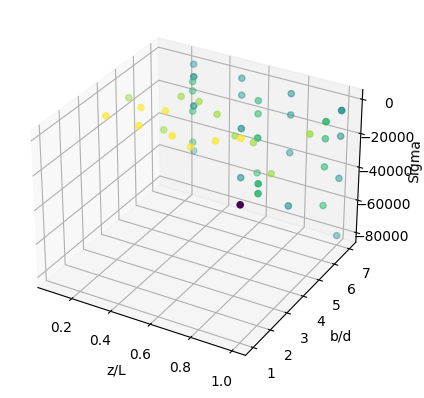

In [114]:
#Visualize the data
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.xlabel("z/L")
plt.ylabel("b/d")
ax.set_zlabel('Sigma')
# for i in range(len(z)):
ax.scatter3D(zL, bd, sig, c=bL, cmap='viridis')

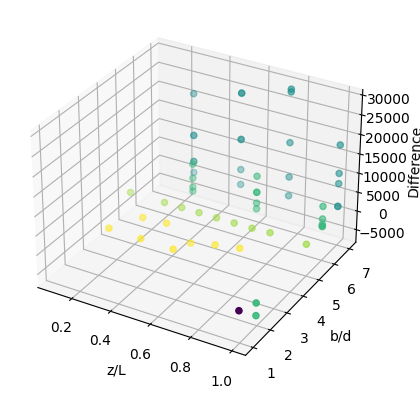

In [115]:
#visualize the data
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.xlabel("z/L")
plt.ylabel("b/d")
ax.set_zlabel('Difference')
ax.scatter3D(zL, bd, Diff, c=bL, cmap='viridis')

In [116]:
# Set up a sequential neural network
model = Sequential()

# Want to set up a network that accepts a value of b/d, z, L, and outputs the stress
# Therefore 2 inputs
# Stack the inputs arrays
input_data = np.stack([zL, bd, bL], axis=1)
input_data_normalized = (input_data - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)
Diff_normalized = (Diff - np.mean(Diff)) / np.std(Diff)

# First split the data into a training set and a temporary set.
input_train, input_temp, Diff_train, Diff_temp = train_test_split(input_data_normalized, Diff_normalized, test_size=0.3)

# Then split the temp_set into a validation set and a testing set.
input_val, input_test, Diff_val, Diff_test = train_test_split(input_temp, Diff_temp, test_size=0.5)




# # Add L2 regularization and dropout for the hidden layers
model.add(Dense(units=3, activation='gelu', input_dim=3, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=6, activation='gelu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=6, activation='gelu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=6, activation='gelu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='softplus'))

#learning rate
optimizer = Adam(lr=0.001)

# Compile the model
model.compile(loss="mean_squared_error", optimizer=optimizer)

start_time = time.time()

# Fit the data 
# Include validation data
history = model.fit(input_train, Diff_train, epochs=8000, batch_size=64, validation_data=(input_val, Diff_val))

end_time = time.time()


Epoch 1/8000


c:\Users\shivm\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 1s 871ms/step - loss: 1.9722 - val_loss: 1.9772
Epoch 2/8000
1/1 [==============================] - 0s 25ms/step - loss: 1.8550 - val_loss: 1.9770
Epoch 3/8000
1/1 [==============================] - 0s 37ms/step - loss: 1.8209 - val_loss: 1.9768
Epoch 4/8000
1/1 [==============================] - 0s 36ms/step - loss: 1.7966 - val_loss: 1.9766
Epoch 5/8000
1/1 [==============================] - 0s 34ms/step - loss: 1.9436 - val_loss: 1.9764
Epoch 6/8000
1/1 [==============================] - 0s 32ms/step - loss: 1.8396 - val_loss: 1.9762
Epoch 7/8000
1/1 [==============================] - 0s 37ms/step - loss: 1.7775 - val_loss: 1.9761
Epoch 8/8000
1/1 [==============================] - 0s 35ms/step - loss: 1.7128 - val_loss: 1.9760
Epoch 9/8000
1/1 [==============================] - 0s 32ms/step - loss: 1.7475 - val_loss: 1.9759
Epoch 10/8000
1/1 [==============================] - 0s 28ms/step - loss: 1.7695 - val_loss: 1.9758
Epoch 11/8000
1/1 [==

In [117]:
# Calculate execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

# Evaluate the model on the test set
test_loss = model.evaluate(input_test, Diff_test, verbose=0)
print(f"Test loss: {test_loss}")

Execution time: 320.8523643016815 seconds
Test loss: 0.6691072583198547


1/1 [==============================] - 0s 130ms/step


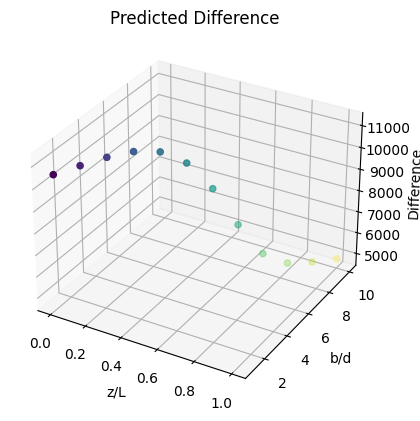

In [118]:
# Generate the grid for the test data
bdtest = np.linspace(1, 10, 12)
zLtest = np.linspace(0, 1, 12)
bLtest = np.linspace(0, 0.1, 12)
bd_grid, zL_grid, bL_grid = np.meshgrid(bdtest, zLtest, bLtest)

# # Reshape the test data arrays to 1D
# bd_1d = bd_grid.ravel()
# zL_1d = zL_grid.ravel()
# bL_1d = bL_grid.ravel()

# Stack the test input data
input_test = np.stack([zLtest, bdtest, bLtest], axis=1)

# Normalize the test input data using the mean and standard deviation from the training data
input_test_normalized = (input_test - np.mean(input_data, axis=0)) / np.std(input_data, axis=0)

# Predict the Diff values for the test input data
predicted_Diff_normalized = model.predict(input_test_normalized)

# De-normalize the predicted Diff values
predicted_Diff = predicted_Diff_normalized * np.std(Diff) + np.mean(Diff)

# # Reshape the predicted Diff values to match the grid shape
# predicted_Diff_grid = predicted_Diff.reshape(bd_grid.shape)

# Visualize the predicted Diff values using a 3D scatter plot
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(zLtest, bdtest,predicted_Diff, c=bLtest, cmap='viridis')
plt.xlabel("z/L")
plt.ylabel("b/d")
ax.set_zlabel('Difference')
plt.title("Predicted Difference")
plt.show()
